# Filtering pyfar Signals

Filtering signals is a very common task in acoustics signal processing and pyfar provides different options for this task that are explored in the following examples.

In [1]:
import pyfar as pf
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

## Filtering with `pyfar.dsp.filter`

The [pyfar.dsp.filter](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.filter.html) module contains a variety of common filter functions including filter banks, bell, and shelve filters, as well as classic filter types such as low-passes and band-passes. See the [example notebook](https://pyfar-gallery.readthedocs.io/en/latest/gallery/interactive/pyfar_filter_types.html) for an overview. Using the filter module is the simplest way to filter a pyfar Signal object. As the following example of a low-pass shows, the function in the filter module takes a Signal object as input and directly returns the filtered Signal
.

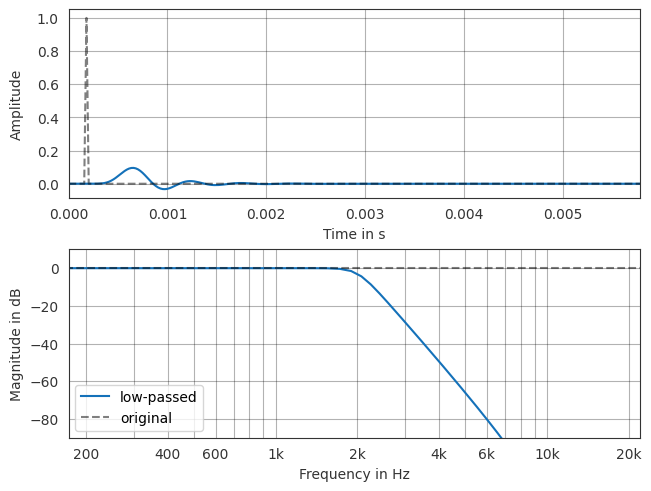

In [2]:
# impulse with 8 samples delay
impulse = pf.signals.impulse(256, 8)

# directly apply 8th order low-pass at 2 kHz
impulse_low_passed = pf.dsp.filter.butterworth(impulse, 8, 2000)

# plot impulse before and after filtering
ax = pf.plot.time_freq(impulse_low_passed, label='low-passed')
ax = pf.plot.time_freq(impulse, c=[0, 0, 0, .5], ls='--', label='original')
ax[1].legend()
plt.show()

Note that the functions can also return the Filter object itself. Directly using Filter objects offers more flexibility as the following examples illustrate.

## Creating Filter objects

pyfar stores filters in *Filter* ojects. These objects are used behind the scenes of the [pyfar.dsp.filter](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.filter.html) module but can also be created by the user. Three different filter types are available in pyfar

- [FIR Filter:](https://pyfar.readthedocs.io/en/stable/classes/pyfar.filter.html#pyfar.classes.filter.FilterFIR) Finite Impulse Response (FIR) filters are non-recursive filters. FIR filters are very flexible and can have arbitrary magnitude and phase responses. One example for an FIR filter is an impulse response.
- [IIR Filter:](https://pyfar.readthedocs.io/en/stable/classes/pyfar.filter.html#pyfar.classes.filter.FilterIIR) Infinite Impulse Response (IIR) filters are recursive filters. They can achieve steeper filter slopes than FIR filters of the same order but are less flexible with respect to the phase response.
- [SOS Filter:](https://pyfar.readthedocs.io/en/stable/classes/pyfar.filter.html#pyfar.classes.filter.FilterSOS) Second Order Section (SOS) filters are cascaded 2nd order recursive filters. They are often more robust against numerical errors than IIR filters of the same order and are thus the most common way of realizing IIR filters.

The application of a Filter is identical across the three types. Signals can be filtered using the `process` method of theFilter object. The filter types only differ in the way the filter coefficients are entered. The following examples show how to create and apply filter objects to audio signals using a simple IIR filter.

A filter object is initialized with the filter coefficients and a sampling rate. For example, an IIR filter requires a set of b-coefficients and a-coefficients, like this simple comb filter example

In [3]:
# design filter coefficients
b = [1, 0, 0]
a = [1, 0, .95]
coefficients = np.stack((b, a), 0)

# create filter object
comb_filter = pf.FilterIIR(coefficients, 44100)

For convenience a summary of the filter can be obtained if it is printed

In [4]:
print(comb_filter)

2nd order IIR filter with 1 channel @ 44100 Hz sampling rate


## Filtering a signal with a Filter object

To filter an audio signal, pass it to the filter's `process` function. As a simple example, lets filter an impulse signal and plot the result to inspect the filter

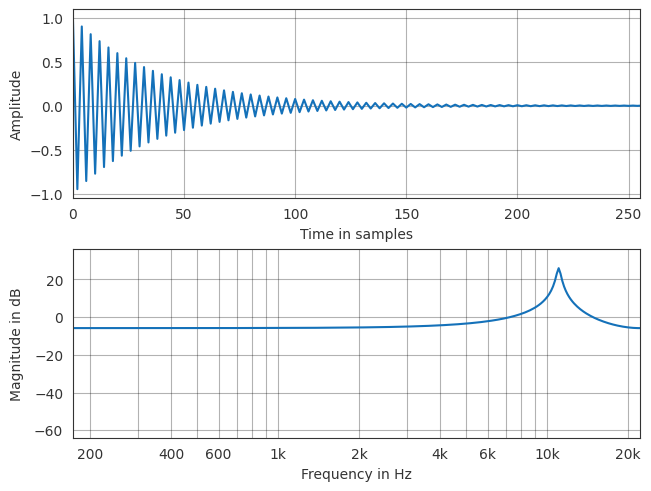

In [5]:
input_signal = pf.signals.impulse(256)
output_signal = comb_filter.process(input_signal)

ax = pf.plot.time_freq(output_signal, unit='samples')
plt.show()

### Filtering with multi-channel Filters

pyfar also contains filter banks, which can be seen as a collection of filters or a multi-channel filter. One example is the [Gammatone filter bank](https://pyfar.readthedocs.io/en/stable/modules/pyfar.dsp.filter.html#pyfar.dsp.filter.GammatoneBands), which is implemented as a filter class (in the future all filter banks in pyfar will be classes). If we apply a multi-channel filter, the output becomes multi-channel as well.

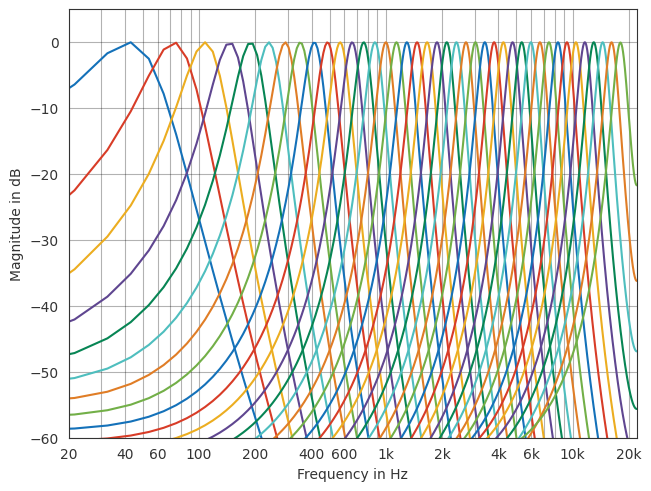

In [6]:
# Create the filter bank
Gammatones = pf.dsp.filter.GammatoneBands(frequency_range=[20, 20_000])

# Apply the filter bank to an impulse with a duration of 4096 samples
impulse_filter_bank, _ = Gammatones.process(pf.signals.impulse(4096))
ax = pf.plot.freq(impulse_filter_bank)
ax.set_ylim(-60, 5)
plt.show()

### Block-wise filtering

In the examples above, the output will be the same no matter how often `process` is called. This default behavior is often desired. In some cases, like block-wise filtering of a signal, the filter object can track the state of the filter. By default, the filter state is set to `None`, but a different state can be set at any time. This requires the `cshape` of the signal that will be filtered and the kind of state. 

In [7]:
comb_filter.init_state(input_signal.cshape, 'zeros')

Now, the same result as above can be obtained in blockwise processing

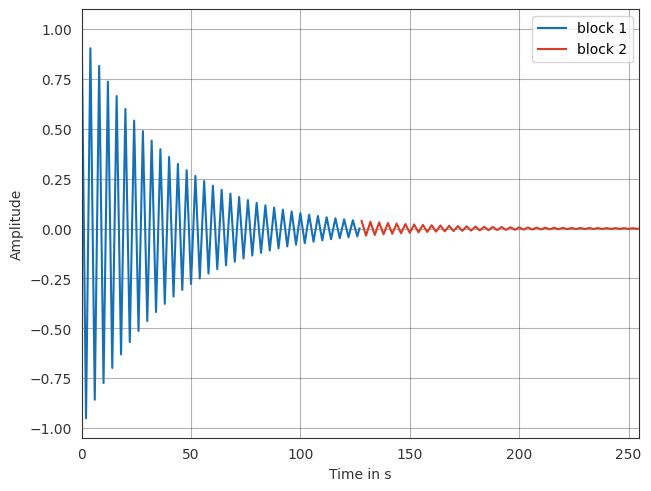

In [8]:
# compute first 128 samples
block_1 = comb_filter.process(
    pf.Signal(input_signal.time[:, :128], input_signal.sampling_rate))
# compute last 128 samples
block_2 = comb_filter.process(
    pf.Signal(input_signal.time[:, 128:], input_signal.sampling_rate))

# plotting the time signals of both blocks
ax = pf.plot.time(block_1, unit='samples', label='block 1')
pf.plot.time(pf.TimeData(block_2.time, np.arange(128)+128), label='block 2')
ax.legend()
plt.show()

### Time-variant and block-wise filtering

If tracking the state of a filter object is enabled as in the example above, a time-variant filter can be realized by changing the filter coefficients between calls of the `process` function. Note that this however, only works if the order of the filter does not change.

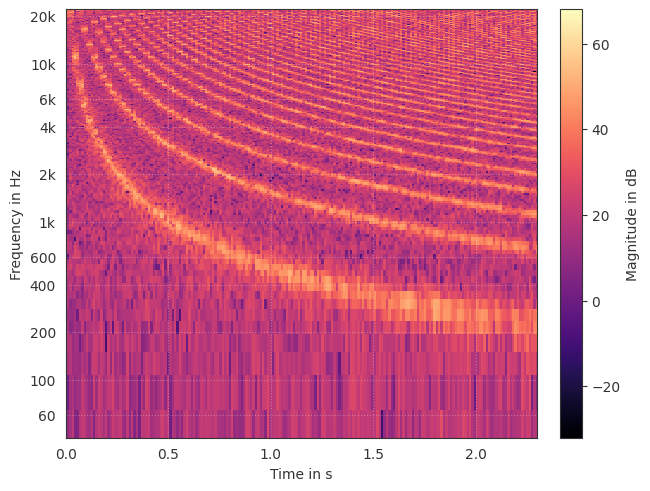

In [9]:
# design initial filter coefficients
order = 100
b = np.zeros(order + 1)
b[0] = 1

# create filter object
comb_filter = pf.FilterIIR(np.stack((b, b), 0), 44100)
comb_filter.init_state(input_signal.cshape, 'zeros')

# design input signal
block_size = 1024
input_signal = pf.signals.noise(
    order * block_size, sampling_rate=comb_filter.sampling_rate)

# initialize output signal
output_signal = pf.Signal(
    np.zeros(input_signal.n_samples), input_signal.sampling_rate)

for nn in range(1, order + 1):

    # update filter coefficients: increase delay of recursive filter part by
    # one in each block
    comb_filter.coefficients[:, 1, nn] = .95
    if nn > 1:
        comb_filter.coefficients[:, 1, nn-1] = 0

    # filter current block
    block = comb_filter.process(
        pf.Signal(input_signal.time[:, nn*block_size:(nn+1)*block_size],
                  input_signal.sampling_rate))

    # write block to output signal
    output_signal.time[:, nn*block_size:(nn+1)*block_size] = block.time

pf.plot.spectrogram(
    output_signal, window_length=block_size, freq_scale='log')
plt.show()

The plot shows that the resonance frequency decreases with increasing delay, and that new resonance frequencies start to emerge at frequencies that are multiples of the first resonance. Listen to this, if you want:

In [10]:
Audio(pf.dsp.normalize(output_signal).time, rate=output_signal.sampling_rate)

# License notice
This notebook © 2024 by [the pyfar developers](https://github.com/orgs/pyfar/people) is licensed under [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/?ref=chooser-v1)

![CC BY Large](../../resources/cc-by.svg)


# Watermark

In [11]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.10.17
IPython version      : 8.37.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1029-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.10.7
numpy     : 2.2.6
IPython   : 8.37.0
pyfar     : 0.7.3

